# Creating ImageNet-Captions

This notebook creates embeddings for the ImageNet-Captions dataset for various embedding models: CLIP, BERT, and GPT-2. This dataset is created using a subset of ImageNet images that are from the 50 most frequent classes from the original validation set, with captions retrieved from the original Flickr posts. 

In [8]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Retrieve Subset of the Original Training Set

Please see the original [ImageNet-Captions](https://github.com/mlfoundations/imagenet-captions) for background on this dataset. This dataset is specified by a a subset of ImageNet images that whose original source was Flickr; these images are paired with their original captions. We use a subset of this dataset with approximately 200k images. The image filename and caption for each training example are listed in the `data/imagenet_captions_train_c250.csv` file. We assume that the `imagenet_images_flickr` folder exists within the `DATA_PATH` specified below.

In [9]:
NUM_CLASSES = 250
DATA_PATH = f'/mnt/ssd/ronak/datasets/imagenet_captions_{NUM_CLASSES}k' # TODO: Change this to the location on your machine.
DEVICE = 'cuda:0'

In [10]:
train_df = pd.read_csv(f"../data/imagenet_captions_train_c{NUM_CLASSES}.csv", header=0, sep="\t")
val_df = pd.read_csv(f"../data/imagenet_captions_val_c{NUM_CLASSES}.csv", header=0, sep="\t")
class_df = pd.read_csv("../data/map_clsloc.txt", sep=" ", header=None)

class_df.columns = ["directory", "class_idx", "class_name"]
train_df

,title,filepath
0,120-2060_IMG,imagenet_images_flickr/n01871265/229706807.jpg
1,127-2701_IMG,imagenet_images_flickr/n01871265/229749569.jpg
2,Tusker,imagenet_images_flickr/n01871265/48085040.jpg
3,Old Tusker,imagenet_images_flickr/n01871265/2039863126.jpg
4,IMG_0031,imagenet_images_flickr/n01871265/2105099569.jpg
...,...,...
174589,Royal Albatross (Northern),imagenet_images_flickr/n02058221/2362697397.jpg
174590,albatross,imagenet_images_flickr/n02058221/3334244815.jpg
174591,mollymawk 3,imagenet_images_flickr/n02058221/79045502.jpg
174592,Laysan albatross w/ chick,imagenet_images_flickr/n02058221/2517173423.jpg


We also keep track of the class label (in both index and natural language) of each example when creating the dataset.

In [11]:
class_df = class_df.set_index("directory")
class_df

,class_idx,class_name
directory,,
n02119789,1,kit_fox
n02100735,2,English_setter
n02110185,3,Siberian_husky
n02096294,4,Australian_terrier
n02102040,5,English_springer
...,...,...
n03063599,996,coffee_mug
n04116512,997,rubber_eraser
n04325704,998,stole


We confirm that the class labels match the folders correctly.

folder n01871265 corresponds to class tusker.


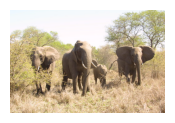

In [12]:
files = list(train_df['filepath'])
files = [os.path.join(DATA_PATH, f) for f in files]
folder = os.path.split(files[0])[0].split("/")[-1]
class_name = class_df.loc[folder]['class_name']

print(f"folder {folder} corresponds to class {class_name}.")


img = mpimg.imread(files[0])

fig, ax = plt.subplots(figsize=(2, 2))
ax.axis("off")
ax.imshow(img)
plt.show()

In [22]:
def add_class_columns(df):
    df['directory'] = df['filepath'].map(lambda x: os.path.split(x)[0].split("/")[-1])
    df['class_name'] = df['directory'].map(lambda x: class_df.loc[x]['class_name'])
    df['class_idx'] = df['directory'].map(lambda x: class_df.loc[x]['class_idx'])
    return df

train_df = add_class_columns(train_df)
val_df = add_class_columns(val_df)

train_class_labels = train_df[["class_name", "class_idx"]]
val_class_labels = val_df[["class_name", "class_idx"]]

We save a version of the filenames and captions that includes the absolute file path provided above.

In [15]:
for split in ["train", "val"]:
    df = pd.read_csv(f"../data/imagenet_captions_{split}_c{NUM_CLASSES}.csv", header=0, sep="\t")
    df["filepath"] = df["filepath"].map(lambda x: os.path.join(DATA_PATH, x))
    df.to_csv(f"{DATA_PATH}/imagenet_captions_{split}_c{NUM_CLASSES}.csv", index=False, sep="\t")

## Create Image and Text Embeddings using CLIP ViT-B/32

We use [ViT-B/32](https://github.com/ronakdm/open_clip_dev/blob/main/docs/PRETRAINED.md) model trained on LAION-2B, which reaches an ImageNet top-1 zero-shot accuracy of 65.62%. While we compute both the image and text embeddings, we ensure that the embeddings from two **separate** CLIP models are used when combining both high-quality embeddings. Please ensure that [OpenCLIP](https://github.com/mlfoundations/open_clip) is installed.

In [16]:
import open_clip
from training.data import get_data, CsvDataset
from training.params import parse_args
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler

MODEL_NAME = "vit_b32_laion2b"

In [18]:
# load model
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model.to(DEVICE)
tokenizer = open_clip.get_tokenizer('ViT-B-32')

print("Log scale:", model.logit_scale)
print("Scale:", model.logit_scale.exp())

Log scale: Parameter containing:
tensor(4.6052, device='cuda:0', requires_grad=True)
Scale: tensor(100., device='cuda:0', grad_fn=<ExpBackward0>)


In [19]:
params = [
    "--train-data", f"{DATA_PATH}/imagenet_captions_train_c{NUM_CLASSES}.csv",
    "--val-data", f"{DATA_PATH}/imagenet_captions_val_c{NUM_CLASSES}.csv",
    "--dataset-type", "csv",
    "--csv-img-key", "filepath",
    "--csv-caption-key", "title"
]
args = parse_args(params)
args.distributed = False

Adjust the batch size below based on your GPU memory constraints.

In [21]:
# Create dataloader from scratch to not drop last
is_train = True
input_filename = args.train_data if is_train else args.val_data
assert input_filename
dataset = CsvDataset(
    input_filename,
    preprocess_train,
    img_key=args.csv_img_key,
    caption_key=args.csv_caption_key,
    sep=args.csv_separator,
    tokenizer=tokenizer,
)
num_samples = len(dataset)
sampler = DistributedSampler(dataset) if args.distributed and is_train else None
shuffle = is_train and sampler is None

dataloader = DataLoader(
    dataset,
    batch_size=512,
    shuffle=shuffle,
    num_workers=args.workers,
    pin_memory=True,
    sampler=sampler,
    drop_last=False,
)
dataloader.num_samples = num_samples
dataloader.num_batches = len(dataloader)

Test that dataset order from dataloader agrees with original dataset order.

torch.Size([512, 3, 224, 224])
torch.Size([512, 77])


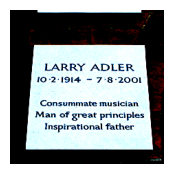

<start_of_text>golders green crematorium - nw 1 1 <end_of_text>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
class_name    brass
class_idx       716
Name: 17654, dtype: object


In [23]:
for i, batch in enumerate(dataloader):
    idx, images, texts = batch
    break

print(images.shape)
print(texts.shape)

batch_id = 0

# show image from dataloader
img = images[batch_id].numpy().transpose([1, 2, 0])
fig, ax = plt.subplots(figsize=(2, 2))
ax.axis("off")
ax.imshow(img)
plt.show()

# show decoded text from dataloader
txt = texts[batch_id]
print(tokenizer.decode([elem.item() for elem in txt]))

# show caption for dataset
print(train_class_labels.loc[idx[batch_id].item()])


Finally, we can generate the embeddings.

In [ ]:
if os.path.exists(os.path.join(DATA_PATH, f"{MODEL_NAME}_image_features.npy")):
    print("found embeddings - loading...")
    all_image_features = np.load(os.path.join(DATA_PATH, f"{MODEL_NAME}_image_features.npy"))
    all_text_features = np.load(os.path.join(DATA_PATH, f"{MODEL_NAME}_text_features.npy"))
    all_idx = np.load(os.path.join(DATA_PATH, f"{MODEL_NAME}_idx.npy"))
else:
    all_image_features, all_text_features, all_idx = [], [], []
    with torch.no_grad():
        for i, batch in tqdm(enumerate(dataloader)):
            idx, images, texts = batch
            image_features = model.encode_image(images.to(DEVICE))
            text_features = model.encode_text(texts.to(DEVICE))
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            all_image_features.append(image_features)
            all_text_features.append(text_features)
            all_idx.append(idx)
            
    all_image_features = torch.cat(all_image_features).cpu().detach().numpy()
    all_text_features = torch.cat(all_text_features).cpu().detach().numpy()
    all_idx = torch.cat(all_idx).cpu().detach().numpy()

    # Because the indices were random, we reorder them to be in line with the original dataset order.
    reorder = np.argsort(all_idx)
    np.save(os.path.join(DATA_PATH, f"{MODEL_NAME}_image_features.npy"), all_image_features[reorder])
    np.save(os.path.join(DATA_PATH, f"{MODEL_NAME}_text_features.npy"), all_text_features[reorder])
    np.save(os.path.join(DATA_PATH, f"{MODEL_NAME}_idx.npy"), all_idx[reorder])

print(all_image_features.shape)
print(all_text_features.shape)
print(all_idx.shape)

## Create Text Embeddings using BERT

In [24]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, BertForMaskedLM
from training.params import parse_args
from torch.utils.data.distributed import DistributedSampler

MODEL_NAME = "bert-base-uncased"

In [25]:
class CsvTextDataset(Dataset):
    def __init__(self, input_filename, tokenizer, caption_key, sep="\t"):
        df = pd.read_csv(input_filename, sep=sep)
        self.captions = df[caption_key].tolist()
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        text = self.captions[idx]
        encoded_input = tokenizer(
            text, 
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=32,
            # pad_to_max_length=True,
            truncation=True,
            padding='max_length',
            return_tensors="pt",  # Return pytorch tensors.return_tensors='pt'
            return_attention_mask=True,
        )
        return idx, encoded_input["input_ids"][0], encoded_input["attention_mask"][0]

In [26]:
model = BertForMaskedLM.from_pretrained(
    "bert-base-uncased",
    output_attentions=False,
    output_hidden_states=True,
).to(DEVICE)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

params = [
    "--train-data", f"{DATA_PATH}/imagenet_captions_train_c{NUM_CLASSES}.csv",
    "--val-data", f"{DATA_PATH}/imagenet_captions_val_c{NUM_CLASSES}.csv",
    "--dataset-type", "csv",
    "--csv-img-key", "filepath",
    "--csv-caption-key", "title"
]
args = parse_args(params)
args.distributed = False

# Create dataloader from scratch to not drop last
is_train = True
input_filename = args.train_data if is_train else args.val_data
assert input_filename
dataset = CsvTextDataset(
    input_filename,
    tokenizer,
    caption_key=args.csv_caption_key,
    sep=args.csv_separator,
)
num_samples = len(dataset)
sampler = DistributedSampler(dataset) if args.distributed and is_train else None
shuffle = is_train and sampler is None

dataloader = DataLoader(
    dataset,
    batch_size=256,
    shuffle=shuffle,
    num_workers=args.workers,
    pin_memory=True,
    sampler=sampler,
    drop_last=False,
)
dataloader.num_samples = num_samples
dataloader.num_batches = len(dataloader)

We run a similar test as before to ensure that the dataloader is working properly. The shape of the output is printed to confirm that the correct object is being queried from the Huggingface output. In this case, we take the hidden representation of the last token from each sequence.

In [28]:
for i, batch in enumerate(dataloader):
    idx, texts, masks = batch
    lens = torch.tensor([mask.sum().item() for mask in masks])
    break

print(texts.shape)

with torch.no_grad():
    out = model(input_ids=texts.to(DEVICE), attention_mask=masks.to(DEVICE))
feat = out["hidden_states"][-1][0, :, :]
print(feat.shape)
print(torch.stack([out["hidden_states"][-1][i, :lens[i], :].mean(dim=0) for i in range(len(lens))]).shape)

batch_id = 0

# show decoded text from dataloader
txt = texts[batch_id]
print(tokenizer.decode([elem.item() for elem in txt]))

# show caption for dataset
print(train_class_labels.loc[idx[batch_id].item()])

torch.Size([256, 32])
torch.Size([32, 768])
torch.Size([256, 768])
[CLS] night pan : nyc taxi [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
class_name    cab
class_idx     267
Name: 123196, dtype: object


In [ ]:
if os.path.exists(os.path.join(DATA_PATH, f"{MODEL_NAME}_text_features.npy")):
    print("found embeddings - loading...")
    all_text_features = np.load(os.path.join(DATA_PATH, f"{MODEL_NAME}_text_features.npy"))
    all_idx = np.load(os.path.join(DATA_PATH, f"{MODEL_NAME}_idx.npy"))
else:
    all_text_features, all_idx = [], []
    with torch.no_grad():
        for i, batch in tqdm(enumerate(dataloader)):
            idx, texts, masks = batch
            lens = torch.tensor([mask.sum().item() for mask in masks])
            out = model(input_ids=texts.to(DEVICE), attention_mask=masks.to(DEVICE))
            text_features = torch.stack([out["hidden_states"][-1][i, 0:lens[i], :].mean(dim=0) for i in range(len(texts))])
            text_features /= text_features.norm(dim=-1, keepdim=True)
            all_text_features.append(text_features)
            all_idx.append(idx)
            
    all_text_features = torch.cat(all_text_features).cpu().detach().numpy()
    all_idx = torch.cat(all_idx).cpu().detach().numpy()

    # Because the indices were random, we reorder them to be in line with the original dataset order.
    reorder = np.argsort(all_idx)
    np.save(os.path.join(DATA_PATH, f"{MODEL_NAME}_text_features.npy"), all_text_features[reorder])
    np.save(os.path.join(DATA_PATH, f"{MODEL_NAME}_idx.npy"), all_idx[reorder])

print(all_text_features.shape)
print(all_idx.shape)

## Create Text Embeddings using GPT-2

In [29]:
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from training.params import parse_args
from torch.utils.data.distributed import DistributedSampler

MODEL_NAME = "gpt2-small"

In [30]:
class CsvTextDataset(Dataset):
    def __init__(self, input_filename, tokenizer, caption_key, sep="\t"):
        df = pd.read_csv(input_filename, sep=sep)
        self.captions = df[caption_key].tolist()
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        text = self.captions[idx]
        encoded_input = tokenizer(
            text, 
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=32,
            # pad_to_max_length=True,
            truncation=True,
            padding='max_length',
            return_tensors="pt",  # Return pytorch tensors.return_tensors='pt'
            return_attention_mask=True,
        )
        return idx, encoded_input["input_ids"][0], encoded_input["attention_mask"][0]

In [31]:
model = GPT2LMHeadModel.from_pretrained(f'gpt2', output_hidden_states=True).to(DEVICE)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [32]:
tokenizer = GPT2Tokenizer.from_pretrained(f'gpt2')
tokenizer.pad_token = tokenizer.eos_token

params = [
    "--train-data", f"{DATA_PATH}/imagenet_captions_train_c{NUM_CLASSES}.csv",
    "--val-data", f"{DATA_PATH}/imagenet_captions_val_c{NUM_CLASSES}.csv",
    "--dataset-type", "csv",
    "--csv-img-key", "filepath",
    "--csv-caption-key", "title"
]
args = parse_args(params)
args.distributed = False

# Create dataloader from scratch to not drop last
is_train = True
input_filename = args.train_data if is_train else args.val_data
assert input_filename
dataset = CsvTextDataset(
    input_filename,
    tokenizer,
    caption_key=args.csv_caption_key,
    sep=args.csv_separator,
)
num_samples = len(dataset)
sampler = DistributedSampler(dataset) if args.distributed and is_train else None
shuffle = is_train and sampler is None

batch_size = 256
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=args.workers,
    pin_memory=True,
    sampler=sampler,
    drop_last=False,
)
dataloader.num_samples = num_samples
dataloader.num_batches = len(dataloader)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Similar to BERT, we print the output of one batch from the dataloader.

In [33]:
for i, batch in enumerate(dataloader):
    idx, texts, masks = batch
    lens = torch.tensor([mask.sum().item() for mask in masks])
    break

print(texts.shape)

with torch.no_grad():
    out = model(input_ids=texts.to(DEVICE), attention_mask=masks.to(DEVICE))
feat = out["hidden_states"][-1][0, :, :]
print(feat.shape)
print(torch.stack([out["hidden_states"][-1][i, :lens[i], :].mean(dim=0) for i in range(len(lens))]).shape)

batch_id = 0

# show decoded text from dataloader
txt = texts[batch_id]
print(tokenizer.decode([elem.item() for elem in txt]))

# show caption for dataset
print(train_class_labels.loc[idx[batch_id].item()])

torch.Size([256, 32])
torch.Size([32, 768])
torch.Size([256, 768])
Striped Ground Cricket - Allonemobius fasciatus<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
class_name    cricket
class_idx         632
Name: 49491, dtype: object


In [ ]:
if os.path.exists(os.path.join(DATA_PATH, f"{MODEL_NAME}_text_features.npy")):
    print("found embeddings - loading...")
    all_text_features = np.load(os.path.join(DATA_PATH, f"{MODEL_NAME}_text_features.npy"))
    all_idx = np.load(os.path.join(DATA_PATH, f"{MODEL_NAME}_idx.npy"))
else:
    all_text_features, all_idx = [], []
    with torch.no_grad():
        for i, batch in tqdm(enumerate(dataloader)):
            idx, texts, masks = batch
            lens = torch.tensor([mask.sum().item() for mask in masks])
            out = model(input_ids=texts.to(DEVICE), attention_mask=masks.to(DEVICE))
            text_features = torch.stack([out["hidden_states"][-1][i, 0:lens[i], :].mean(dim=0) for i in range(len(texts))])
            text_features /= text_features.norm(dim=-1, keepdim=True)
            all_text_features.append(text_features)
            all_idx.append(idx)
            
    all_text_features = torch.cat(all_text_features).cpu().detach().numpy()
    all_idx = torch.cat(all_idx).cpu().detach().numpy()

    # Because the indices were random, we reorder them to be in line with the original dataset order.
    reorder = np.argsort(all_idx)
    np.save(os.path.join(DATA_PATH, f"{MODEL_NAME}_text_features.npy"), all_text_features[reorder])
    np.save(os.path.join(DATA_PATH, f"{MODEL_NAME}_idx.npy"), all_idx[reorder])

print(all_text_features.shape)
print(all_idx.shape)

## Create Text Embeddings using CLIP (Separately Trained)

As mentioned before, we also use embeddings from another CLIP model with the same architechture but trained on a different dataset (DataCompXL). This is so that the embeddings used are from separately trained models, and we do not train an MLP on top of embeddings that were already jointly trained.

In [34]:
import open_clip
from training.data import get_data, CsvDataset
from training.params import parse_args
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler

MODEL_NAME = "vit_b32_datacompxl"

# list other options within open clip
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN50-quickgelu', 'openai'),
 ('RN50-quickgelu', 'yfcc15m'),
 ('RN50-quickgelu', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN101-quickgelu', 'openai'),
 ('RN101-quickgelu', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_xl_s13b_b90k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_

In [35]:
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('ViT-B-32', pretrained='datacomp_xl_s13b_b90k')
model.to(DEVICE)
tokenizer = open_clip.get_tokenizer('ViT-B-32')

print("Log scale:", model.logit_scale)
print("Scale:", model.logit_scale.exp())

open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Log scale: Parameter containing:
tensor(4.6052, device='cuda:0', requires_grad=True)
Scale: tensor(100., device='cuda:0', grad_fn=<ExpBackward0>)


In [36]:
params = [
    "--train-data", f"{DATA_PATH}/imagenet_captions_train_c{NUM_CLASSES}.csv",
    "--val-data", f"{DATA_PATH}/imagenet_captions_val_c{NUM_CLASSES}.csv",
    "--dataset-type", "csv",
    "--csv-img-key", "filepath",
    "--csv-caption-key", "title"
]
args = parse_args(params)
args.distributed = False

In [37]:
# Create dataloader from scratch to not drop last
is_train = True
input_filename = args.train_data if is_train else args.val_data
assert input_filename
dataset = CsvDataset(
    input_filename,
    preprocess_train,
    img_key=args.csv_img_key,
    caption_key=args.csv_caption_key,
    sep=args.csv_separator,
    tokenizer=tokenizer,
)
num_samples = len(dataset)
sampler = DistributedSampler(dataset) if args.distributed and is_train else None
shuffle = is_train and sampler is None

dataloader = DataLoader(
    dataset,
    batch_size=256,
    shuffle=shuffle,
    num_workers=args.workers,
    pin_memory=True,
    sampler=sampler,
    drop_last=False, # TODO: Changed from original
)
dataloader.num_samples = num_samples
dataloader.num_batches = len(dataloader)

torch.Size([256, 3, 224, 224])
torch.Size([256, 77])


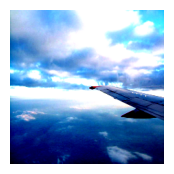

<start_of_text>aeroplane wing <end_of_text>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
class_name    wing
class_idx      503
Name: 95989, dtype: object


In [38]:
for i, batch in enumerate(dataloader):
    idx, images, texts = batch
    break

print(images.shape)
print(texts.shape)

batch_id = 0

# show image from dataloader
img = images[batch_id].numpy().transpose([1, 2, 0])
fig, ax = plt.subplots(figsize=(2, 2))
ax.axis("off")
ax.imshow(img)
plt.show()

# show decoded text from dataloader
txt = texts[batch_id]
print(tokenizer.decode([elem.item() for elem in txt]))

# show caption for dataset
print(train_class_labels.loc[idx[batch_id].item()])

In [ ]:
if os.path.exists(os.path.join(DATA_PATH, f"{MODEL_NAME}_image_features.npy")):
    print("found embeddings - loading...")
    all_image_features = np.load(os.path.join(DATA_PATH, f"{MODEL_NAME}_image_features.npy"))
    all_text_features = np.load(os.path.join(DATA_PATH, f"{MODEL_NAME}_text_features.npy"))
    all_idx = np.load(os.path.join(DATA_PATH, f"{MODEL_NAME}_idx.npy"))
else:
    all_image_features, all_text_features, all_idx = [], [], []
    with torch.no_grad():
        for i, batch in tqdm(enumerate(dataloader)):
            idx, images, texts = batch
            image_features = model.encode_image(images.to(DEVICE))
            text_features = model.encode_text(texts.to(DEVICE))
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            all_image_features.append(image_features)
            all_text_features.append(text_features)
            all_idx.append(idx)
            
    all_image_features = torch.cat(all_image_features).cpu().detach().numpy()
    all_text_features = torch.cat(all_text_features).cpu().detach().numpy()
    all_idx = torch.cat(all_idx).cpu().detach().numpy()

    # Because the indices were random, we reorder them to be in line with the original dataset order.
    reorder = np.argsort(all_idx)
    np.save(os.path.join(DATA_PATH, f"{MODEL_NAME}_image_features.npy"), all_image_features[reorder])
    np.save(os.path.join(DATA_PATH, f"{MODEL_NAME}_text_features.npy"), all_text_features[reorder])
    np.save(os.path.join(DATA_PATH, f"{MODEL_NAME}_idx.npy"), all_idx[reorder])

print(all_image_features.shape)
print(all_text_features.shape)
print(all_idx.shape)